# TuRBO Bayesian Optimization
In this tutorial we demonstrate the use of Xopt to preform Trust Region Bayesian
Optimization (TuRBO) on a simple test problem. During optimization of high
dimensional input spaces off the shelf BO tends to over-emphasize exploration which
severely degrades optimization performance. TuRBO attempts to prevent this by
maintaining a surrogate model over a local (trust) region centered on the best
observation so far and restricting optimization inside that local region. The trust
region is expanded and contracted based on the number of `successful` (observations
that improve over the best observed point) or `unsuccessful` (no improvement)
observations in a row. See https://botorch.org/tutorials/turbo_1 for details.

## Define the test problem
Here we define a simple optimization problem, where we attempt to minimize a
function in the domian [0,2*pi]. Note that the function used to evaluate the
objective function takes a dictionary as input and returns a dictionary as the output.

In [1]:
from xopt.vocs import VOCS
import math

# define variables and function objectives
vocs = VOCS(
    variables={"x": [0, 2 * math.pi]},
    objectives={"f": "MINIMIZE"},
)

In [2]:
# define a test function to optimize
import numpy as np

def sin_function(input_dict):
    x = input_dict["x"]
    return {"f": -10*np.exp(-(x - np.pi)**2 / 0.01) + 0.5*np.sin(5*x)}

## Create Xopt objects
Create the evaluator to evaluate our test function and create a generator that uses
the Upper Confidence Bound acquisition function to perform Bayesian Optimization.

In [3]:
from xopt.evaluator import Evaluator
from xopt.generators.bayesian import UpperConfidenceBoundGenerator
from xopt import Xopt


evaluator = Evaluator(function=sin_function)
generator = UpperConfidenceBoundGenerator(
    vocs=vocs, turbo_controller="optimize"
)
X = Xopt(evaluator=evaluator, generator=generator, vocs=vocs)

In [4]:
X


            Xopt
________________________________
Version: 0+untagged.1.g7a7eff9
Data size: 0
Config as YAML:
dump_file: null
evaluator:
  function: __main__.sin_function
  function_kwargs: {}
  max_workers: 1
  vectorized: false
generator:
  beta: 2.0
  computation_time: null
  fixed_features: null
  gp_constructor:
    covar_modules: {}
    mean_modules: {}
    name: standard
    trainable_mean_keys: []
    transform_inputs: true
    use_low_noise_prior: true
  log_transform_acquisition_function: false
  max_travel_distances: null
  model: null
  n_candidates: 1
  n_interpolate_points: null
  n_monte_carlo_samples: 128
  name: upper_confidence_bound
  numerical_optimizer:
    max_iter: 2000
    max_time: null
    n_restarts: 20
    name: LBFGS
  supports_batch_generation: true
  turbo_controller:
    batch_size: 1
    best_value: null
    center_x: null
    dim: 1
    failure_counter: 0
    failure_tolerance: 2
    length: 0.25
    length_max: 2.0
    length_min: 0.0078125
    name:

## Generate and evaluate initial points
To begin optimization, we must generate some random initial data points. The first call
to `X.step()` will generate and evaluate a number of randomly points specified by the
 generator. Note that if we add data to xopt before calling `X.step()` by assigning
 the data to `X.data`, calls to `X.step()` will ignore the random generation and
 proceed to generating points via Bayesian optimization.

In [5]:
import pandas as pd
X.evaluate_data(pd.DataFrame({"x":[3.0, 1.75, 2.0]}))

# inspect the gathered data
X.data

,x,f,xopt_runtime,xopt_error
0,3.00,-1.021664,0.000033,False
1,1.75,0.312362,0.000006,False
2,2.00,-0.272011,0.000005,False


In [6]:
# determine trust region from gathered data
X.generator.train_model()
X.generator.turbo_controller.update_state(X.generator.data)
X.generator.turbo_controller.get_trust_region(X.generator.model)

tensor([[2.2146],
        [3.7854]], dtype=torch.float64)

## Do bayesian optimization steps
Notice that when the number of successive successes or failures reaches 2 the trust
region expands or contracts and counters are reset to zero. Counters are also reset
to zero during alternate successes/failures. Finally, the model is most accurate
inside the trust region, which supports our goal of local optimization.

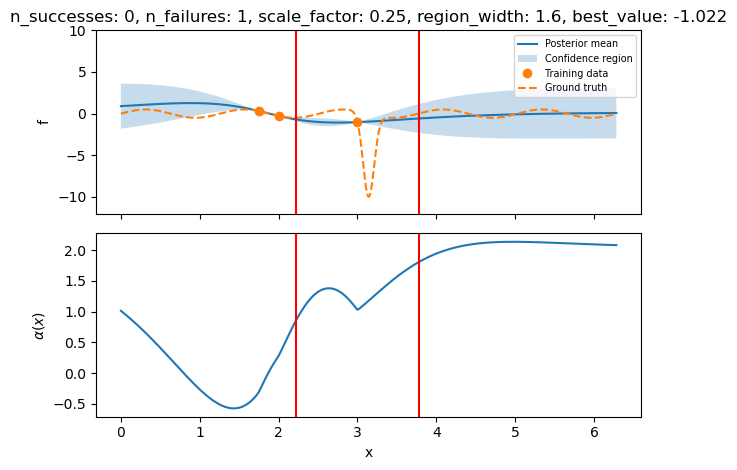

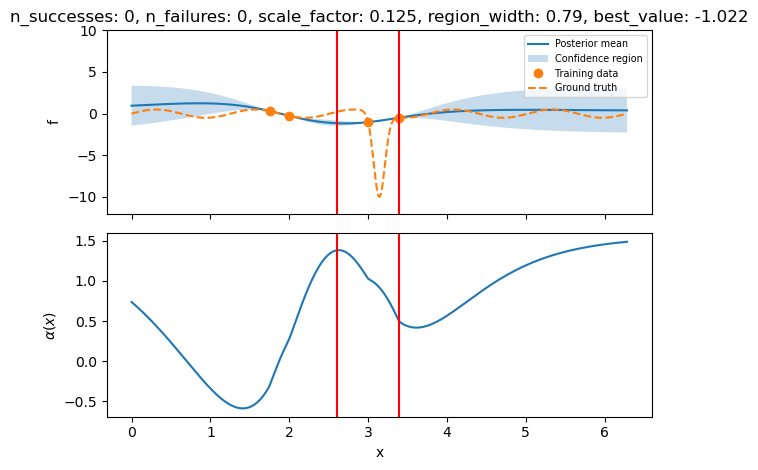

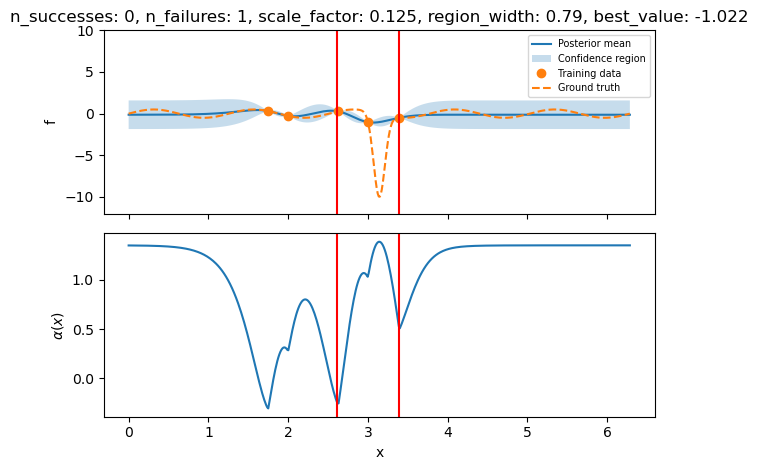

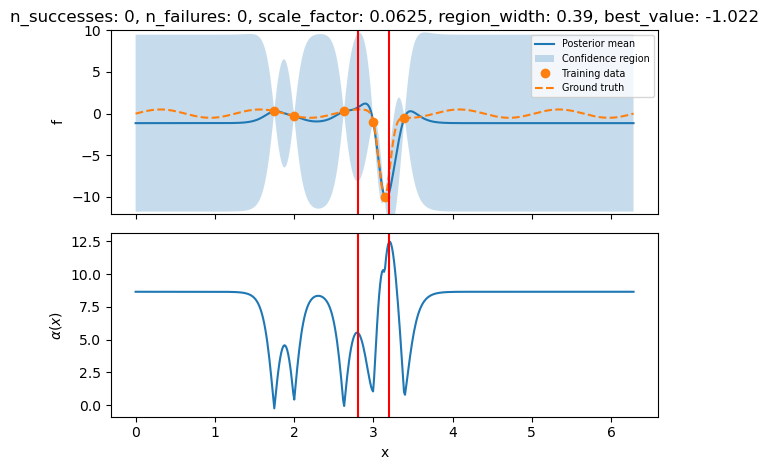

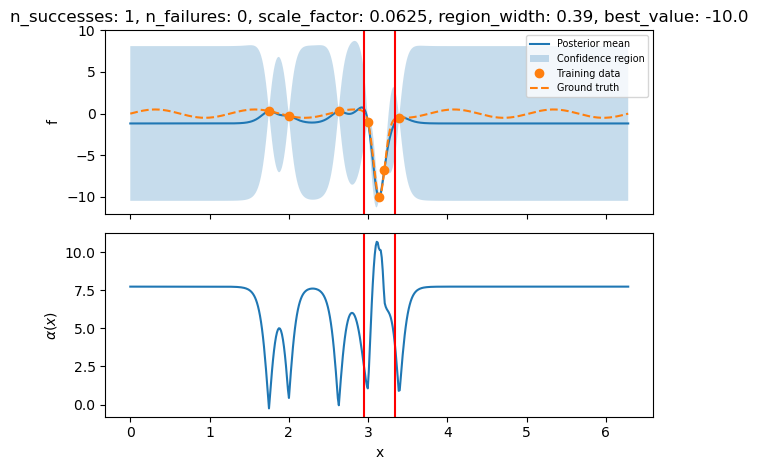

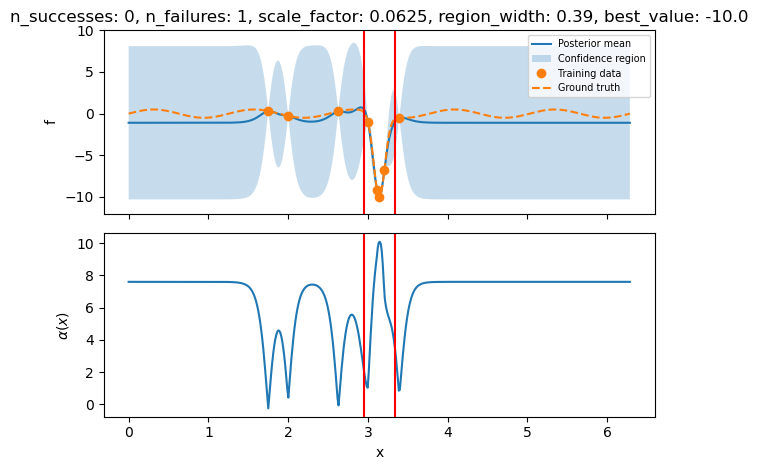

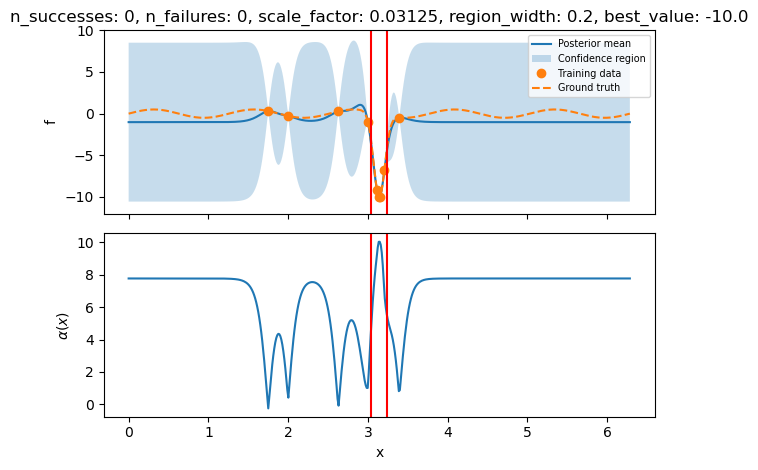

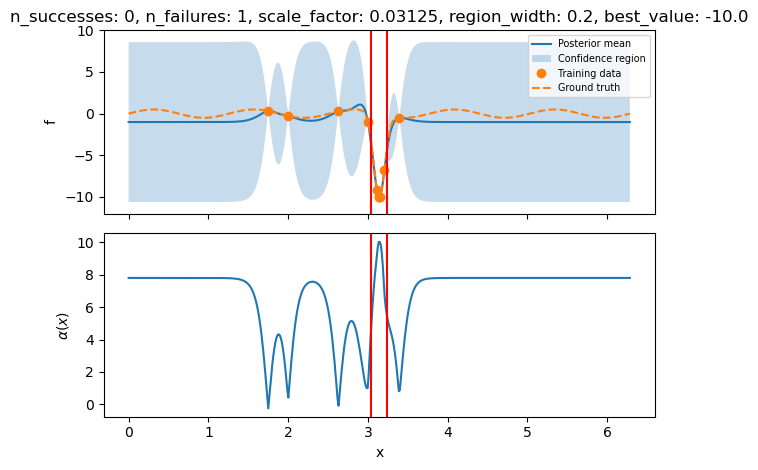

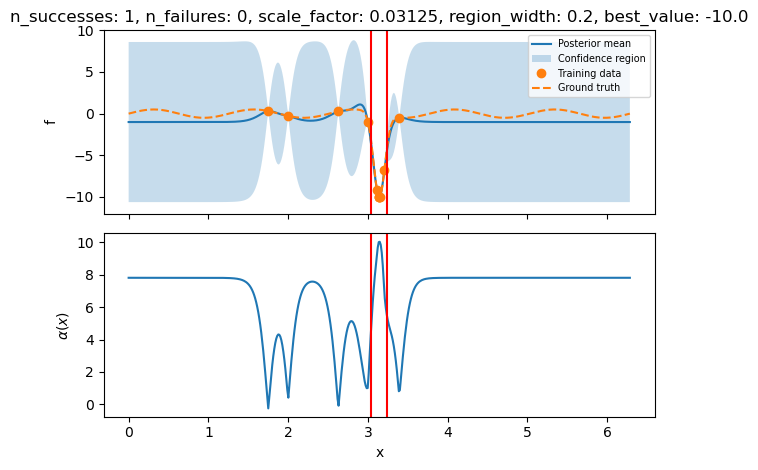

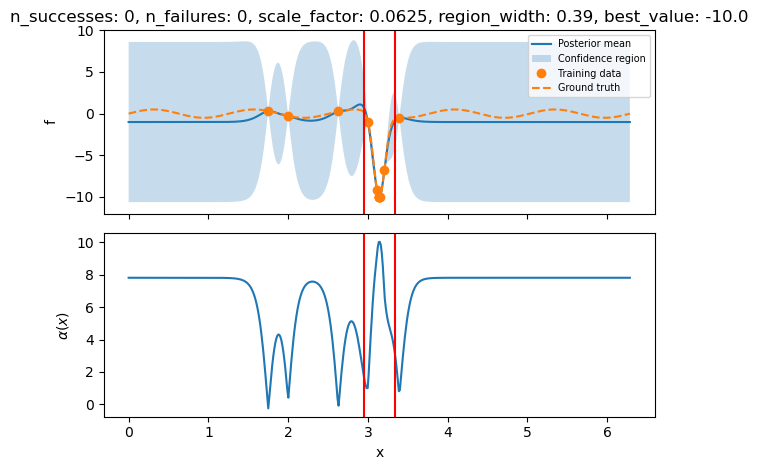

In [7]:
import torch
import matplotlib.pyplot as plt

# test points for plotting
test_x = torch.linspace(*X.vocs.bounds.flatten(),500).double()

for i in range(10):

    # get the Gaussian process model from the generator
    model = X.generator.train_model()

    # get trust region
    trust_region = X.generator.turbo_controller.get_trust_region(model)\
        .squeeze()
    scale_factor = X.generator.turbo_controller.length
    region_width = trust_region[1] - trust_region[0]
    best_value = X.generator.turbo_controller.best_value

    # get number of successes and failures
    n_successes = X.generator.turbo_controller.success_counter
    n_failures = X.generator.turbo_controller.failure_counter

    # get acquisition function from generator
    acq = X.generator.get_acquisition(model)

    # calculate model posterior and acquisition function at each test point
    # NOTE: need to add a dimension to the input tensor for evaluating the
    # posterior and another for the acquisition function, see
    # https://botorch.org/docs/batching for details
    # NOTE: we use the `torch.no_grad()` environment to speed up computation by
    # skipping calculations for backpropagation
    with torch.no_grad():
        posterior = model.posterior(test_x.unsqueeze(1))
        acq_val = acq(test_x.reshape(-1,1,1))

    # get mean function and confidence regions
    mean = posterior.mean
    l,u = posterior.mvn.confidence_region()

    # plot model and acquisition function
    fig,ax = plt.subplots(2,1,sharex="all")

    # add title for successes and failures
    ax[0].set_title(f"n_successes: {n_successes}, n_failures: {n_failures}, "
                    f"scale_factor: {scale_factor}, region_width: {region_width:.2}, "
                    f"best_value: {best_value:.4}")

    # plot model posterior
    ax[0].plot(test_x, mean, label="Posterior mean")
    ax[0].fill_between(test_x, l, u,alpha=0.25, label="Confidence region")

    # add data to model plot
    ax[0].plot(X.data["x"],X.data["f"],"C1o", label="Training data")

    # plot true function
    true_f = sin_function({"x": test_x})["f"]
    ax[0].plot(test_x, true_f,'--', label="Ground truth")

    # add legend
    ax[0].legend(fontsize="x-small")

    # plot acquisition function
    ax[1].plot(test_x, acq_val.flatten())

    ax[0].set_ylabel("f")
    ax[0].set_ylim(-12,10)
    ax[1].set_ylabel(r"$\alpha(x)$")
    ax[1].set_xlabel("x")

    # plot trust region
    for a in ax:
        a.axvline(trust_region[0],c="r")
        a.axvline(trust_region[1],c="r")

    fig.tight_layout()
    X.step()


In [8]:
# access the collected data
X.generator.turbo_controller

OptimizeTurboController(vocs=VOCS(variables={'x': [0.0, 6.283185307179586]}, constraints={}, objectives={'f': 'MINIMIZE'}, constants={}, observables=[]), dim=1, batch_size=1, length=0.0625, length_min=0.0078125, length_max=2.0, failure_counter=0, failure_tolerance=2, success_counter=1, success_tolerance=2, center_x={'x': 3.1421063677657464}, scale_factor=2.0, tkwargs={'dtype': torch.float64}, name='optimize', best_value=-10.001020385255307)

In [9]:
X.data

,x,f,xopt_runtime,xopt_error
0,3.000000,-1.021664,0.000033,False
1,1.750000,0.312362,0.000006,False
2,2.000000,-0.272011,0.000005,False
3,3.392699,-0.493621,0.000011,False
4,2.628499,0.272390,0.000011,False
5,3.141806,-10.000489,0.000011,False
6,3.205876,-6.773020,0.000011,False
7,3.114312,-9.214808,0.000011,False
8,3.149690,-9.954879,0.000033,False
9,3.140919,-9.997862,0.000010,False


In [10]:
list(model.named_parameters())

[('models.0.likelihood.noise_covar.raw_noise',
  Parameter containing:
  tensor([-25.0732], dtype=torch.float64, requires_grad=True)),
 ('models.0.mean_module.raw_constant',
  Parameter containing:
  tensor(0.9513, dtype=torch.float64, requires_grad=True)),
 ('models.0.covar_module.raw_outputscale',
  Parameter containing:
  tensor(0.5314, dtype=torch.float64, requires_grad=True)),
 ('models.0.covar_module.base_kernel.raw_lengthscale',
  Parameter containing:
  tensor([[-3.7730]], dtype=torch.float64, requires_grad=True))]